# Projeto #2 - Classificador supervisionado

Antes de começar, leia as [Instruções](https://github.com/thvmm/pos-ds-ia/tree/master/projeto_2#instru%C3%A7%C3%B5es) e os [Critérios de Avaliação](https://github.com/thvmm/pos-ds-ia/tree/master/projeto_2#crit%C3%A9rios-de-avalia%C3%A7%C3%A3o)


### 1) Qual a base escolhida?

O dataset consiste em 20 grupos de notícias, que compreende cerca de 18.000 postagens de notícias, sobre 20 tópicos divididos em dois subconjuntos: um para treinamento e outro para teste. A divisão entre o treino e o conjunto de teste é baseada em mensagens postadas antes e depois de uma data específica.

Características do dataset:

Features   | Valor
--------- | ------
Classes | 20
Amostras | 18846
Dimensionalidade | 1
Recursos | texto

Link da base: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups



### 2) **(10%)** Pré-processamento: entendimento do conjunto de dados
- Quais são minhas features?
- Quais são minhas classes?
- Como estão distribuidas minhas classes?
- Checagem se os valores estão dentro de um limite permitido ou razoável.
- Tratamento de valores ausentes por eliminação ou substituição.
- Conversão do tipo de dados.


In [0]:
# Implemente sua análise aqui. Use mais blocos se achar que ficará mais organizado.

from __future__ import division, print_function, unicode_literals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
def read_file(filename):
    return pd.read_csv(filename, 
                       header=None, sep='\t', 
                       names=['label', 'text'])

In [53]:
ng20_train_df = read_file('ng20-train-all-terms.txt')
ng20_test_df = read_file('ng20-test-all-terms.txt')

all_dfs = [ng20_train_df, ng20_test_df]

all_df_names = ["ng20_train_df", "ng20_test_df"]

for (df, name) in zip(all_dfs, all_df_names):
    print(name, "(#rows, #columns):", df.shape)
    print(df.head(1))

ng20_train_df (#rows, #columns): (11293, 2)
         label                                               text
0  alt.atheism  alt atheism faq atheist resources archive name...
ng20_test_df (#rows, #columns): (7528, 2)
         label                                               text
0  alt.atheism  re about the bible quiz answers in article hea...


In [0]:
def create_counts_df(df_train, df_test):
    counts_df = pd.concat([df_train["label"].value_counts(), 
                           df_test["label"].value_counts()], 
                          axis=1, keys=["# train docs", "# test docs"])
    counts_df["total # docs"] = counts_df.sum(axis=1)
    counts_df.loc["Total"] = counts_df.sum()
    return counts_df

In [55]:
ng20_counts = create_counts_df(ng20_train_df, ng20_test_df)
ng20_counts

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,# train docs,# test docs,total # docs
alt.atheism,480,319,799
comp.graphics,584,389,973
comp.os.ms-windows.misc,572,394,966
comp.sys.ibm.pc.hardware,590,392,982
comp.sys.mac.hardware,578,385,963
comp.windows.x,593,392,985
misc.forsale,585,390,975
rec.autos,594,395,989
rec.motorcycles,598,398,996
rec.sport.baseball,597,397,994


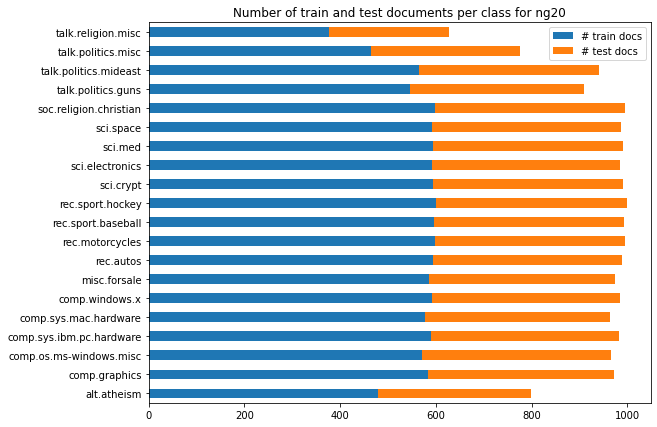

In [56]:
ng20_counts.iloc[:-1,:-1].plot.barh(stacked=True, 
                                    figsize=(9, 7),
                                    title="Number of train and test documents per class for ng20")

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

def describe_dataset(name, df_train):
    print("Dataset:", name)

    cvec = CountVectorizer()
    cvec.fit(df_train["text"])
    with_stop = len(cvec.get_feature_names())
    print("Number of features including stopwords:", with_stop)

    cvec = CountVectorizer(stop_words="english")
    cvec.fit(df_train["text"])
    without_stop = len(cvec.get_feature_names())
    print("Number of features excluding stopwords:", without_stop)
    
    print("Difference in number of features:", with_stop-without_stop)
    return with_stop, without_stop

In [58]:
ng20_with_stop, ng20_without_stop = describe_dataset("ng20", ng20_train_df)

Dataset: ng20
Number of features including stopwords: 73686
Number of features excluding stopwords: 73375
Difference in number of features: 311


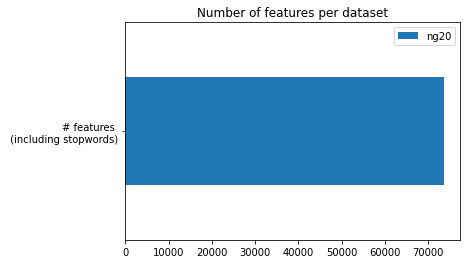

In [59]:
features_df = pd.DataFrame({"ng20": [ng20_with_stop]},
                           index=["# features \n (including stopwords)"])
features_df[["ng20"]].plot.barh(title="Number of features per dataset")

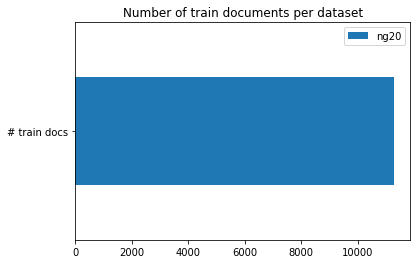

In [60]:
train_docs_df = pd.DataFrame({"ng20": ng20_counts.loc["Total"]["# train docs"]},
                             index=["# train docs"])
train_docs_df[["ng20"]].plot.barh(title="Number of train documents per dataset")

### 3) **(80%)** Nos blocos seguintes implemente seus classificadores (serão implementados 2 métodos diferentes).

#### 3.1) Qual método escolhido?

**Indique o método escolhido**

Vector Method

#### 3.2) **(10%)** Baseline - Implemente seu classificador da forma mais simples possível para esse ser seu baseline

In [0]:
# Implementação. Use mais blocos se achar que ficará mais organizado.

from sklearn.feature_extraction.text import CountVectorizer

def create_word_counts_csv(docs, out_file, stopwords=None):
  
    cvec = CountVectorizer(stop_words=stopwords)
    cvec.fit(docs)

    df = pd.DataFrame(cvec.transform(docs).todense(),
                      columns=cvec.get_feature_names())

    df_word_counts = df.sum(axis=0)
    df_word_counts.sort_values(ascending=False, inplace=True)
    df_word_counts[:50].to_csv(out_file)

#### 3.3) **(20%)** Versão 1 - O que podemos fazer para melhorar nosso baseline? Aplique técnicas como redução de dimensionalidade, normalização ou outras. Compare os resultados.

In [0]:
# Implementação. Use mais blocos se achar que ficará mais organizado.

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix, accuracy_score

In [0]:
def to_tfidf(df_train, df_test):
    vec = TfidfVectorizer(stop_words='english', smooth_idf=False)
    vec.fit(df_train["text"])
    X_train = vec.transform(df_train["text"])
    y_train = df_train["label"]
    X_test = vec.transform(df_test["text"])
    y_test = df_test["label"]
    return X_train, y_train, X_test, y_test
    
def apply_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return score

def apply_models(models, df_train, df_test, use_lsi=False):
    X_train, y_train, X_test, y_test = to_tfidf(df_train, df_test)
    if use_lsi:
        svd = TruncatedSVD(n_components=200, random_state=42)
        X_train = svd.fit_transform(X_train)
        X_test = svd.transform(X_test)

    return [(name, apply_model(model, X_train, y_train, X_test, y_test)) \
            for (name, model) in models]

#### 3.4) **(10%)** Tunning - Agora que temos um resultado promissor, vamos tentar melhorar o resultado alterando um ou mais hiper-parametro. Compare os resultados.

In [0]:
# Implementação. Use mais blocos se achar que ficará mais organizado.

webpage_models = (
    ("Vector Method", KNeighborsClassifier(n_neighbors=1)),
)

In [65]:
ng20_results = apply_models(webpage_models, ng20_train_df, ng20_test_df)
ng20_results

[('Vector Method', 0.7217056323060573)]

#### 3.5) Qual método escolhido?

**Indique o método escolhido**

SVM

#### 3.6) **(10%)** Baseline - Implemente seu classificador da forma mais simples possível para esse ser seu baseline

In [0]:
# Implementação. Use mais blocos se achar que ficará mais organizado.

from sklearn.feature_extraction.text import CountVectorizer

def create_word_counts_csv(docs, out_file, stopwords=None):
  
    cvec = CountVectorizer(stop_words=stopwords)
    cvec.fit(docs)

    df = pd.DataFrame(cvec.transform(docs).todense(),
                      columns=cvec.get_feature_names())

    df_word_counts = df.sum(axis=0)
    df_word_counts.sort_values(ascending=False, inplace=True)
    df_word_counts[:50].to_csv(out_file)

#### 3.7) **(20%)** Versão 1 - O que podemos fazer para melhorar nosso baseline? Aplique técnicas como redução de dimensionalidade, normalização ou outras. Compare os resultados.

In [0]:
# Implementação. Use mais blocos se achar que ficará mais organizado.

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix, accuracy_score

In [0]:
def to_tfidf(df_train, df_test):
    vec = TfidfVectorizer(stop_words='english', smooth_idf=False)
    vec.fit(df_train["text"])
    X_train = vec.transform(df_train["text"])
    y_train = df_train["label"]
    X_test = vec.transform(df_test["text"])
    y_test = df_test["label"]
    return X_train, y_train, X_test, y_test
    
def apply_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return score

def apply_models(models, df_train, df_test, use_lsi=False):
    X_train, y_train, X_test, y_test = to_tfidf(df_train, df_test)
    if use_lsi:
        svd = TruncatedSVD(n_components=200, random_state=42)
        X_train = svd.fit_transform(X_train)
        X_test = svd.transform(X_test)

    return [(name, apply_model(model, X_train, y_train, X_test, y_test)) \
            for (name, model) in models]

#### 3.8) **(10%)** Tunning - Agora que temos um resultado promissor, vamos tentar melhorar o resultado alterando um ou mais hiper-parametro. Compare os resultados.

In [0]:
# Implementação. Use mais blocos se achar que ficará mais organizado.

webpage_models = (
    ("SVM", LinearSVC()),
)

In [70]:
ng20_results = apply_models(webpage_models, ng20_train_df, ng20_test_df)
ng20_results

[('SVM', 0.8471041445270988)]

### 5) **(10%)** Conclusões

*Compare seus resultados. Imaginando que sua solução fosse para produção, qual deles você escolheria? Por que? Quais os riscos você enxerga? O que recomendaria de próximos passos para melhorar os resultados?*

Dentre os dois classificadores o SVM teve um melhor aproveitamento do que o Vector.

O Vector determina a classe de um documento de teste, localizando o documento de treino mais semelhante (usando similaridade de cosseno) e retornando sua classe.

O SVM determina a classe de um documento de teste projetando-o em um hiper-espaço de alta dimensão e determinando em que classe corresponde o "hiper-point" no qual foi projetado.
